### Import packeges

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import time
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path
import xgboost as xgb


In [5]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, swir):
    return (nir - swir) / (nir + swir + 1e-10)

# Function to extract mean NDVI & NDWI as features
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, swir = bands[3], bands[2], bands[4]  # Adjust based on band order
        
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, swir)

        return [np.mean(ndvi), np.mean(ndwi)]  # Use mean as feature

In [6]:
# Load dataset efficiently
train_dataset_path = Path('../../../data/model/Patches/Train/')
test_dataset_path = Path('../../../data/model/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

#### Apply k-Fold Cross-Validation and GridSearchCV

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [01:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
[0]	validation_0-mlogloss:1.13297	validation_1-mlogloss:1.13374
[1]	validation_0-mlogloss:0.96280	validation_1-mlogloss:0.96350
[2]	validation_0-mlogloss:0.84034	validation_1-mlogloss:0.84078
[3]	validation_0-mlogloss:0.74779	validation_1-mlogloss:0.74862
[4]	validation_0-mlogloss:0.67529	validation_1-mlogloss:0.67609
[5]	validation_0-mlogloss:0.61951	validation_1-mlogloss:0.62042
[6]	validation_0-mlogloss:0.57535	validation_1-mlogloss:0.57583
[7]	validation_0-mlogloss:0.53870	validation_1-mlogloss:0.53853
[8]	validation_0-mlogloss:0.50870	validation_1-mlogloss:0.50771
[9]	validation_0-mlogloss:0.48466	validation_1-mlogloss:0.48329
[10]	validation_0-mlogloss:0.46542	validation_1-mlogloss:0.46383
[11]	validation_0-mlogloss:0.44950	validation_1-mlogloss:0.44768
[12]	validation_0-mlogloss:0.43481	validation_1-mlogloss:0.43261
[13]	validation_0-mlogloss:0.42323	validation

c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [01:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-mlogloss:0.36059	validation_1-mlogloss:0.35750
[27]	validation_0-mlogloss:0.35827	validation_1-mlogloss:0.35537
[28]	validation_0-mlogloss:0.35688	validation_1-mlogloss:0.35406
[29]	validation_0-mlogloss:0.35488	validation_1-mlogloss:0.35190
[30]	validation_0-mlogloss:0.35325	validation_1-mlogloss:0.35035
[31]	validation_0-mlogloss:0.35165	validation_1-mlogloss:0.34898
[32]	validation_0-mlogloss:0.35054	validation_1-mlogloss:0.34804
[33]	validation_0-mlogloss:0.34949	validation_1-mlogloss:0.34702
[34]	validation_0-mlogloss:0.34856	validation_1-mlogloss:0.34597
[35]	validation_0-mlogloss:0.34774	validation_1-mlogloss:0.34514
[36]	validation_0-mlogloss:0.34677	validation_1-mlogloss:0.34436
[37]	validation_0-mlogloss:0.34598	validation_1-mlogloss:0.34360
[38]	validation_0-mlogloss:0.34525	validation_1-mlogloss:0.34285
[39]	validation_0-mlogloss:0.34445	validation_1-mlogloss:0.34225
[40]	validation_0-mlogloss:0.34391	validation_1-mlogloss:0.34168
[41]	validation_0-mloglos

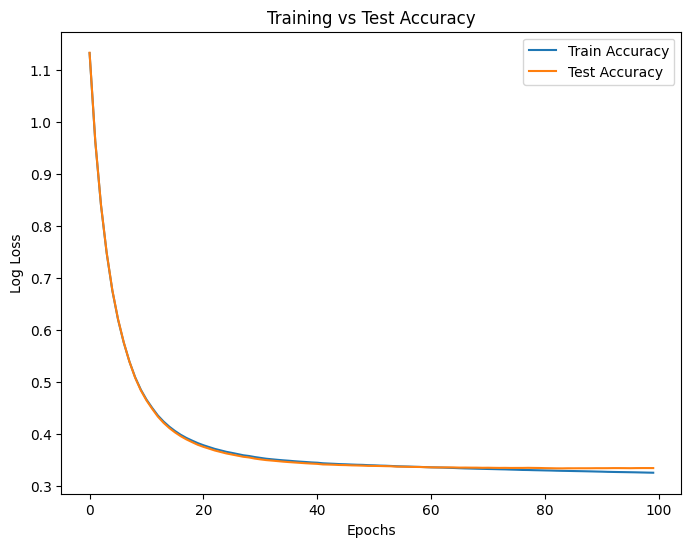

In [7]:
# Define parameter grid for XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Initialize XGBoost and GridSearchCV
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, n_jobs=-1, verbose=2, return_train_score=True)

# Train model with cross-validation
grid_search.fit(X, y)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
history = best_model.fit(X, y, eval_set=[(X, y), (X_test, y_test)], verbose=True)

# Plot training and test accuracy
eval_results = best_model.evals_result()
train_accuracy = eval_results['validation_0']['mlogloss']
test_accuracy = eval_results['validation_1']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.savefig(Path("../../../logs/IMG/NEW/XGB_V2_accuracy_plot.png"))
plt.show()

#### Evaluate Model

Test Accuracy: 0.8685897435897436
Test Precision: 0.866196350582259
Test Recall: 0.8685897435897436
Test F1 Score: 0.8622313950018595
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2071
           1       0.74      0.48      0.59       499
           2       0.95      0.86      0.90       984
           3       0.77      0.90      0.83       502

    accuracy                           0.87      4056
   macro avg       0.84      0.80      0.81      4056
weighted avg       0.87      0.87      0.86      4056

Saved model to: ..\..\..\models\Map\xgb_model_v2.joblib
Best Cross-Validation Accuracy: 86.41%


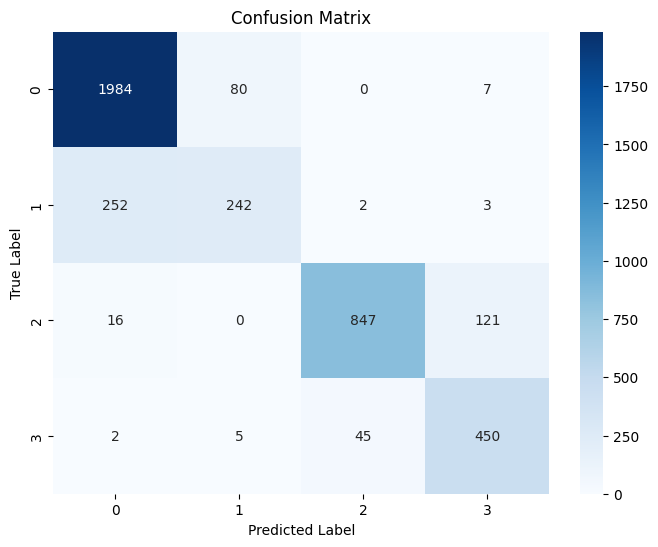

In [8]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path("../../../logs/IMG/XGB_V2_confusion_matrix.png")) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
xgb_model_v2 = Path("../../../models/Map/xgb_model_v2.joblib")
joblib.dump(best_model, xgb_model_v2)
print(f"Saved model to: {xgb_model_v2}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

#### Predict New Images

In [12]:
# Load the best model
model = joblib.load(xgb_model_v2)

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../data/model/Test/ripening/ripening_100FPLAN_31.tif')
predicted_stage = predict_growth_stage(new_image, model)
print(f"Predicted Growth Stage: {predicted_stage}")
print()

Predicted Growth Stage: grand_growth

